# Balanced Creditcard data


In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [27]:
data = pd.read_csv("creditcard.csv")

# Creditcard visualization

As we will shortly see, from data.head() y data.shape we can distinguish  among the different columns:
Time == Time between transaction.
V1-V28 == PCE dimensionality reduction to protect both identity and localization of clients.
Amount ==  Total amount of money.


# Class: IMPORTANT. 
The "Class" column contains 0's {No Fraud} and 1's {Fraud}. Through value_counts we can see how many 1's and 0's actually exist.

In [41]:
print(data.head())
print(data.shape)

(284807, 31)

# Mistakes in the data?
We can also see if there is a bug in the .csv file using data.isnull.sum ()

In [42]:
data.isnull().sum()

amount    0
time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Class     0
dtype: int64

# Highly unbalanced dataset
We see that, in effect, the number of 0's and 1's is heavily unbalanced.

In [43]:
print('No Frauds', round(data['Class'].value_counts()[0]/len(data) * 100, 2), '% of the dataset')
print('Frauds', round(data['Class'].value_counts()[1]/len(data) * 100, 2), '% of the dataset')
print('Fraudulent Transactions', data['Class'].value_counts()[1])

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset
Fraudulent Transactions 492


<AxesSubplot:xlabel='Class', ylabel='count'>

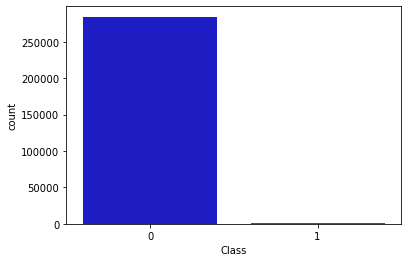

In [44]:
colors = ["#0101DF", "#DF0101"]
sns.countplot('Class', data=data, palette=colors)

# Renormalizing Time and Amount
We have seen in the previous notebook (unbalanced) that this is the cause of an important error when counting 1's (Fraud). To do this, we have to balance this result so that the algorithm does not make a brutal mistake in counting fraud. Similarly, we want to rescale the "Time" and "Amount" columns. This is what we do next.

In [32]:
rob_scaler = RobustScaler()
data['scaled_amount'] = rob_scaler.fit_transform(data['Amount'].values.reshape(-1,1))
data['scaled_time'] = rob_scaler.fit_transform(data['Time'].values.reshape(-1,1))
data.drop(['Time','Amount'], axis=1, inplace=True)
amount = data['scaled_amount']
time = data['scaled_time']
data.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
data.insert(0, 'amount', amount)
data.insert(1, 'time', time)

In [33]:
data.head()

,amount,time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


# Balanced data
Next we rescale the number of Valid transactions == nfraud_data to be the same as the number of fraud == fraud_data. We are then taking care of the above problem, where highly unbalanced data led to a tremendous error in the number of frauds counted. Not so in the total percentage of success, which was high because the number of 0's was practically the number of transactions.

In [45]:
data = data.sample(frac=1)
fraud_data = data.loc[data['Class']==1]
nfraud_data = data.loc[data['Class']==0][:data['Class'].value_counts()[1]]
normal_distributed_df = pd.concat([fraud_data, nfraud_data])
ndata = normal_distributed_df.sample(frac=1, random_state=42)
ndata.head()

,amount,time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
90236,-0.279746,-0.255654,1.294851,0.257285,-0.163464,0.307613,0.231716,-0.093053,-0.053693,0.027824,...,-0.045153,-0.314763,-0.948182,-0.025730,-0.896306,0.334381,0.150622,-0.029703,0.008273,0
27362,-0.286173,-0.589422,1.081234,0.416414,0.862919,2.520863,-0.005021,0.563341,-0.123372,0.223122,...,-0.165249,-0.159387,-0.305154,0.053620,0.011761,0.375146,-0.106299,0.021008,0.010559,1
124832,5.758401,-0.085222,0.604839,-1.886371,-0.554519,-0.174555,-1.244669,-0.729373,0.263710,-0.323298,...,0.313250,-0.226300,-1.065347,-0.412884,0.077673,0.288845,1.071799,-0.156956,0.066526,0
274475,0.250122,0.955556,-0.956390,2.361594,-3.171195,1.970759,0.474761,-1.902598,-0.055178,0.277831,...,0.190877,0.473211,0.719400,0.122458,-0.255650,-0.619259,-0.484280,0.683535,0.443299,1
144754,4.216726,0.019784,-0.670238,0.945206,0.610051,2.640065,-2.707775,1.952611,-1.624608,-5.229908,...,1.474929,-2.504450,1.436472,0.351542,0.648467,0.579681,0.075738,0.346717,0.282209,1


Fraudulent Transactions 492
Non-Fraudulent Transactions 492


<AxesSubplot:xlabel='Class', ylabel='count'>

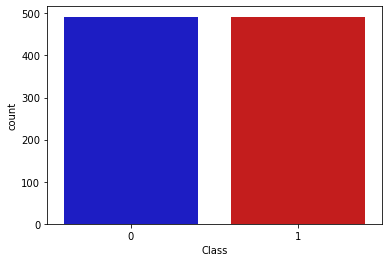

In [46]:
print('Fraudulent Transactions', ndata['Class'].value_counts()[1])
print('Non-Fraudulent Transactions', ndata['Class'].value_counts()[0])
colors = ["#0101DF", "#DF0101"]
sns.countplot('Class', data=ndata, palette=colors)

# Splitting
Next we will filter the values.
To do this, we will create a variable X that contains all the data except the "Class" column and we will create another variable that contains ONLY the data of the "Class" column. In this way we can know how good the algorithm used is. Essentially we will operate on X and then we will compare with the values ​​of Y, which is the pure reality.

In [51]:
dataframe = pd.DataFrame(data = ndata)
X = dataframe.iloc[:, ndata.columns != 'Class']
Y = dataframe.iloc[:, ndata.columns == 'Class']

# Transform X et Y en random train arrays.
Next we will run train_test_split with the previously calculated X and Y values ​​in order to obtain random train and test subsets.

In [52]:
X_train, X_test,y_train,y_test = train_test_split(X, Y, test_size=0.25, random_state=1)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# DecisionTreeClassifier

In [53]:
classifier = DecisionTreeClassifier(criterion = 'gini', random_state= 0 )
classifier.fit(X_train, y_train.ravel())
y_pre = classifier.predict(X_test)

In [54]:
print("DecisionTreeClassifier gives an overall precision of")
print(classifier.score(X_test,y_test))
print(classification_report(y_test,y_pre))

DecisionTreeClassifier gives an overall precision of
0.8983739837398373
              precision    recall  f1-score   support

           0       0.91      0.88      0.90       121
           1       0.89      0.91      0.90       125

    accuracy                           0.90       246
   macro avg       0.90      0.90      0.90       246
weighted avg       0.90      0.90      0.90       246



# RandomForestClassifier

In [55]:
clf = RandomForestClassifier(n_estimators= 50, criterion= 'entropy', random_state=0)
clf.fit(X_train, y_train.ravel())
y_pred = clf.predict(X_test)
print("RandomForestClassifier")
print(clf.score(X_test,y_test))
print(classification_report(y_test,y_pred))

RandomForestClassifier
0.9512195121951219
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       121
           1       0.98      0.92      0.95       125

    accuracy                           0.95       246
   macro avg       0.95      0.95      0.95       246
weighted avg       0.95      0.95      0.95       246



# Conclusions-Conclusiones

We have used two algorithms for classic Machine learning: Decision Tree Classifier and Random Forest Classifier to obtain a LOWER global precision (90%) than in the unbalanced case (99%). However, this has a trick (and a heavy one) because the precision when counting 1's in this case has been 90% (balanced data) while in the unbalanced case it barely reaches 30% in the best of cases (Isolated Forest).
As a conclusion for these classical machine learning models, it is necessary to alter the initial data if it is highly unbalanced since the models need balanced data to recognize differences and similarities. Also, since we deal with less amount of data compared to the unbalanced case (10% of creditcard.csv), we get the results quite faster.


Hemos usado dos algoritmos para Machine learning clásico: Decision Tree Classifier y Random Forest Classifier para obtener una precisión global MENOR (90%) que en el caso unbalanced (99%). Sin embargo, esto tiene truco (y mucho) debido a que la precisión a la hora de contar 1's en este caso ha sido del 90% (balanced data)  mientras que en el caso unbalanced apenas llegaba en el mejor de los casos al 30%
Como conclusión para estos modelos de classical machine learning, es necesario alterar los datos iniciales si son highly unbalanced ya que los modelos necesitan balanced data para reconocer diferencias y similitudes entre los datos. Además, como tratamos con menos cantidad de datos con respecto al caso unbalanced (10% de creditcard.csv), obtenemos los resultados sin una demora computacional. 